In [2]:
from collections import defaultdict
import pandas as pd
import pickle as pkl
import os


def get_evidence_df(ann_folder):
    rows = {}
    for filename in os.listdir(ann_folder):
        with open(os.path.join(ann_folder, filename), 'rb') as f:
            d = pkl.load(f)
            instance_data = next(iter(d.values()))
            anns = instance_data['model_anns']
            if len(anns) > 0:
                assert len(anns) == 1
                model_type = next(iter(anns.keys()))
                anns['model_type'] = model_type
                model_anns = anns[model_type]
                if len(model_anns) > 0:
                    assert len(model_anns['sort_by_model_order']) == 1
                    sort_type = model_anns['sort_by_model_order'][0]
                    anns['sort_type'] = sort_type
                    del model_anns['sort_by_model_order']
                    model_anns['evidence_anns'] = model_anns['evidence_anns'][sort_type]
                    anns.update(model_anns)
                del anns[model_type]
            del instance_data['model_anns']
            instance_data.update(instance_data['info'])
            del instance_data['info']
            instance_data.update(anns)
            rows.update(d)
    return pd.DataFrame(rows).transpose().sort_index()

def get_full_evidence_df(ann_dirs):
    dfs = defaultdict(lambda : pd.DataFrame([]))
    for ann_dir in ann_dirs:
        date = ann_dir.split('/')[-2].split('_')[1]
        for split in os.listdir(ann_dir):
            for annotator in os.listdir(os.path.join(ann_dir, split)):
                df = get_evidence_df(os.path.join(ann_dir, split, annotator))
                df['annotator'] = [annotator] * len(df)
                df['date'] = [date] * len(df)
                dfs[split] = pd.concat([dfs[split], df])
    dfs = {split: df.reset_index() for split, df in dfs.items()}
    annotator_instance_repeats = defaultdict(lambda: [])
    for split, df in dfs.items():
        annotations_to_remove = set()
        for annotator in set(df.annotator):
            annotator_df = df[df.annotator == annotator]
            for instance in set(annotator_df.instance):
                annotator_instance_df = annotator_df[
                    annotator_df.instance == instance]
                if len(annotator_instance_df) > 1:
                    annotator_instance_repeats[split].append(annotator_instance_df)
                    annotations_to_remove.update(set(annotator_instance_df[1:].index))
        dfs[split] = df.drop(index=list(annotations_to_remove))
    return dfs, dict(annotator_instance_repeats)


In [3]:
dfs, annotator_instance_repeats = get_full_evidence_df([
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_9-29-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-3-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-9-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-14-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-16-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-17-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-20-23/annotations',
    '/work/frink/mcinerney.de/ehr-diagnosis-annotations/annotations_11-21-23/annotations',])

In [4]:
print(annotator_instance_repeats.keys(), len(annotator_instance_repeats['val2']))
annotator_instance_repeats['val2'][0]

dict_keys(['val2']) 1


,index,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,...,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,date,action,visited_reports,visited_report_timestamps
15,0,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",271.838545,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,William,11-3-23,"[-3.64162540435791, -2.0485668182373047, -1.93...",NaN,NaN
47,3,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",100.098678,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,William,11-20-23,"[-3.64162540435791, -2.048567056655884, -1.931...","[10. 198151.0 - Radiology: ""[**2180-10-18**] 1...","[0.0007648468017578125, 29.769817113876343, 58..."


In [5]:
dfs['val2'][dfs['val2'].instance == "val2 Instance 69 (patient 11480, 158 reports)"]

,index,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,...,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,date,action,visited_reports,visited_report_timestamps
7,2,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",155.551828,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,11-3-23,"[-5.879974842071533, -1.8629225492477417, -2.7...",NaN,NaN
15,0,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",271.838545,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,William,11-3-23,"[-3.64162540435791, -2.0485668182373047, -1.93...",NaN,NaN


In [6]:
dfs['val2']['evidence_anns'].iloc[0]

{10: {'cancer': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'pneumonia': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'pulmonary edema': {'relevance': '1 - Weak Correlation', 'impact': 'Yes'},
  'evidence_was_seen': 'Yes',
  'notes': 'Only one piece of relevant evidence because huge gap in the medical record between recent report and past reports.',
  'evidence': {'score': '0.96',
   'evidence': "The liver is nodular and coarse in echotexture, consistent with patient's history of known cirrhosis. The gallbladder wall is thickened, with a dependent gallstone within it. A moderate amount of",
   'query': 'cancer (diagnosis)',
   'day': -387,
   'report_number': '20'},
  'sorted_idx': 0,
  'evidence_distribution': [2.884256362915039,
   -2.276189088821411,
   -1.170615315437317]}}

In [7]:
dfs['val2']

,index,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,...,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,date,action,visited_reports,visited_report_timestamps
0,0,"{'options': 'option,type cancer,diagnosis pneu...",1,26,"val2 Instance 50 (patient 11755, 122 reports)",168.272657,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",19,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
1,1,"{'options': 'option,type cancer,diagnosis pneu...",1,42,"val2 Instance 51 (patient 7470, 53 reports)",189.534721,{pulmonary edema (diagnosis)},NaN,21,None,...,NaN,NaN,NaN,NaN,,Andrea,9-29-23,NaN,NaN,NaN
2,2,"{'options': 'option,type cancer,diagnosis pneu...",1,1,"val2 Instance 52 (patient 83375, 8 reports)",24.683878,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",7,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
3,3,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 53 (patient 94023, 4 reports)",29.90608,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
4,4,"{'options': 'option,type cancer,diagnosis pneu...",1,2,"val2 Instance 54 (patient 26310, 32 reports)",46.365206,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",3,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,9-29-23,NaN,NaN,NaN
5,5,"{'options': 'option,type cancer,diagnosis pneu...",1,24,"val2 Instance 55 (patient 5255, 25 reports)",158.251378,{cancer (diagnosis)},NaN,1,None,...,NaN,NaN,NaN,NaN,,Andrea,9-29-23,NaN,NaN,NaN
6,1,"{'options': 'option,type cancer,diagnosis pneu...",1,12,"val2 Instance 67 (patient 1973, 36 reports)",45.904525,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",39,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,11-3-23,"[-3.8275794982910156, -1.8324410915374756, -1....",NaN,NaN
7,2,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",155.551828,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,11-3-23,"[-5.879974842071533, -1.8629225492477417, -2.7...",NaN,NaN
8,3,"{'options': 'option,type cancer,diagnosis pneu...",1,11,"val2 Instance 76 (patient 7097, 16 reports)",98.346124,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",9,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,11-3-23,"[-4.060123443603516, -2.017209529876709, -1.12...",NaN,NaN
9,4,"{'options': 'option,type cancer,diagnosis pneu...",1,17,"val2 Instance 85 (patient 19303, 52 reports)",89.775001,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",15,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...","History of CHF, should we mark it as confident...",NaN,Andrea,11-3-23,"[-2.4307668209075928, -2.5343399047851562, -1....",NaN,NaN


In [8]:

dfs['val2'][dfs['val2'].instance == "val2 Instance 69 (patient 11480, 158 reports)"]

,index,obs,timestep,num_reports,instance,time_for_initial_assesment,seen_targets,option_likelihood_anns,max_timesteps,true_positives,...,options,selected_options,option_likelihood_anns2,concluding_notes,invalid_instance_notes,annotator,date,action,visited_reports,visited_report_timestamps
7,2,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",155.551828,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,Andrea,11-3-23,"[-5.879974842071533, -1.8629225492477417, -2.7...",NaN,NaN
15,0,"{'options': 'option,type cancer,diagnosis pneu...",1,10,"val2 Instance 69 (patient 11480, 158 reports)",271.838545,{},"{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",295,None,...,"[cancer (diagnosis), pneumonia (diagnosis), pu...","[0, 1, 2]","{'cancer (diagnosis)': 'Unlikely', 'pneumonia ...",,NaN,William,11-3-23,"[-3.64162540435791, -2.0485668182373047, -1.93...",NaN,NaN


In [9]:
from collections import defaultdict
def get_processed_annotations(df, remove_duplicates=True):
    new_rows = []
    for i, row in df.iterrows():
        new_rows.append({
            'annotator': row['annotator'],
            'instance_index': row['instance_index'],
            'num_reports': row['num_reports'],
            'model_type': row['model_type'],
            'sort_type': row['sort_type'],
            'prediction_aligns': 1 if row['prediction_aligns'] == 'Yes' else 0 if row['prediction_aligns'] == row['prediction_aligns'] else None,
            'time_for_initial_assesment': row['time_for_initial_assesment'],
        })
        if row['options'] == row['options']:
            for condition in row['options']:
                condition = condition.split(' (')[0]
                new_rows[-1][condition + ' in future'] = condition in row['future_true_positives']
            evidence_anns = sorted([{'idx': k, **v} for k, v in row['evidence_anns'].items()], key=lambda x: x['sorted_idx'])
            new_evidence_anns = defaultdict(lambda: [])
            new_rows[-1]['num_annotated_evidence'] = len(evidence_anns)
            for x in evidence_anns:
                is_duplicate = 'duplicate' in x['notes'].lower() \
                    if 'notes' in x.keys() else False
                if remove_duplicates and is_duplicate:
                    continue
                new_evidence_anns['is_duplicate'].append(is_duplicate)
                new_evidence_anns['notes'].append(
                    x['notes'] if 'notes' in x.keys() else None)
                evidence_info = x['evidence']
                for k, v in evidence_info.items():
                    new_evidence_anns[k].append(v)
                new_evidence_anns['evidence_was_seen'].append(
                    x['evidence_was_seen'] if 'evidence_was_seen' in x.keys()
                    else None)
                for condition in row['options']:
                    condition = condition.split(' (')[0]
                    new_evidence_anns[condition + ' relevance'].append(int(
                        x[condition]['relevance'].split()[0]))
                    new_evidence_anns[condition + ' impact'].append(
                        x[condition]['impact'] if 'impact' in x[condition].keys()
                        else None)
            new_rows[-1].update(new_evidence_anns)
        if row['option_likelihood_anns'] == row['option_likelihood_anns']:
            new_rows[-1].update({k.split(' (')[0]: v for k, v in row['option_likelihood_anns'].items()})
            new_rows[-1].update({k.split(' (')[0] + '(changed)': v for k, v in row['option_likelihood_anns2'].items() if v != row['option_likelihood_anns'][k]})
    new_df = pd.DataFrame(new_rows)
    return new_df


In [10]:
processed_df = get_processed_annotations(dfs['val2'])
processed_df

,annotator,instance_index,num_reports,model_type,sort_type,prediction_aligns,time_for_initial_assesment,cancer in future,pneumonia in future,pulmonary edema in future,...,cancer impact,pneumonia relevance,pneumonia impact,pulmonary edema relevance,pulmonary edema impact,cancer,pneumonia,pulmonary edema,cancer(changed),pneumonia(changed)
0,Andrea,49,26,llm_evidence,LLM Confidence,1.0,168.272657,False,True,True,...,[Yes],[1],[Yes],[1],[Yes],Unlikely,Somewhat likely,Somewhat likely,NaN,NaN
1,Andrea,50,42,llm_evidence,NaN,NaN,189.534721,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Andrea,51,1,llm_evidence,LLM Confidence,0.0,24.683878,False,False,True,...,"[None, None]","[1, 0]","[No, None]","[1, 0]","[No, None]",Unlikely,Unlikely,Unlikely,NaN,NaN
3,Andrea,52,2,llm_evidence,LLM Confidence,1.0,29.906080,False,False,False,...,"[None, None, None]","[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]",Unlikely,Unlikely,Somewhat likely,NaN,NaN
4,Andrea,53,2,llm_evidence,Sort by MSE with the bias logits,0.0,46.365206,False,False,True,...,[None],[1],[Yes],[1],[Yes],Unlikely,Unlikely,Unlikely,NaN,NaN
5,Andrea,54,24,llm_evidence,NaN,NaN,158.251378,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Andrea,66,12,llm_evidence,LLM Confidence,1.0,45.904525,False,False,True,...,"[None, None, None]","[0, 0, 0]","[None, None, None]","[0, 0, 0]","[None, None, None]",Unlikely,Unlikely,Somewhat likely,NaN,NaN
7,Andrea,68,10,all_sentences,Sort by MSE with the bias logits,0.0,155.551828,False,False,False,...,"[None, None]","[1, 1]","[No, No]","[1, 1]","[No, Yes]",Unlikely,Unlikely,Somewhat likely,NaN,NaN
8,Andrea,75,11,all_sentences,Sort by MSE with the bias logits,0.0,98.346124,False,False,False,...,"[None, None, None, None, None]","[0, 0, 0, 0, 0]","[None, None, None, None, None]","[0, 0, 0, 0, 0]","[None, None, None, None, None]",Unlikely,Very likely,Unlikely,NaN,NaN
9,Andrea,84,17,llm_evidence,LLM Confidence,1.0,89.775001,False,False,True,...,"[None, None]","[0, 0]","[None, None]","[0, 0]","[None, None]",Unlikely,Unlikely,Unlikely,NaN,NaN


In [11]:
processed_df.keys()

Index(['annotator', 'instance_index', 'num_reports', 'model_type', 'sort_type',
       'prediction_aligns', 'time_for_initial_assesment', 'cancer in future',
       'pneumonia in future', 'pulmonary edema in future',
       'num_annotated_evidence', 'is_duplicate', 'notes', 'score', 'evidence',
       'query', 'day', 'report_number', 'evidence_was_seen',
       'cancer relevance', 'cancer impact', 'pneumonia relevance',
       'pneumonia impact', 'pulmonary edema relevance',
       'pulmonary edema impact', 'cancer', 'pneumonia', 'pulmonary edema',
       'cancer(changed)', 'pneumonia(changed)'],
      dtype='object')

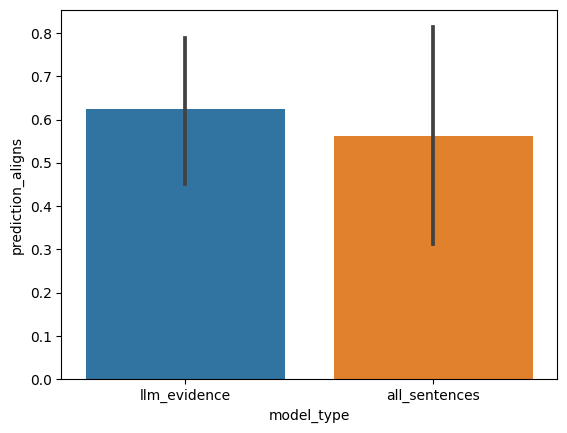

/work/frink/mcinerney.de/envs/ehrenvint/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='model_type', ylabel='prediction_aligns'>

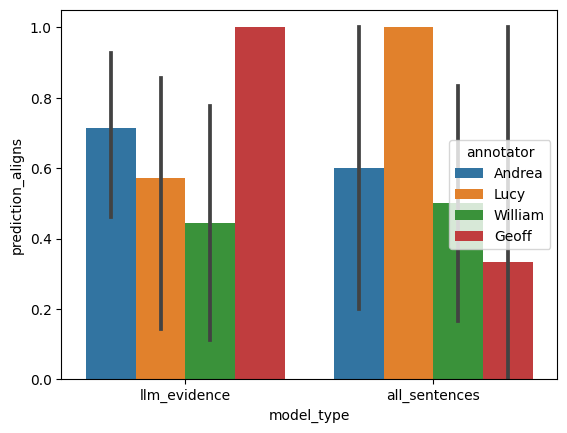

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=processed_df, y='prediction_aligns', x='model_type')
plt.show()
sns.barplot(data=processed_df, y='prediction_aligns', x='model_type', hue='annotator')

In [28]:
evidence_df = []
for i, row in processed_df.iterrows():
    impacts = {}
    if row['evidence'] != row['evidence']:
        continue
    all_notes = row['notes'] if row['notes'] == row['notes'] else [None] * len(row['evidence'])
    all_queries = row['query'] if row['query'] == row['query'] else [None] * len(row['evidence'])
    all_days = row['day'] if row['day'] == row['day'] else [None] * len(row['day'])
    if row['cancer impact'] == row['cancer impact']:
        impacts['cancer'] = row['cancer impact']
    if row['pneumonia impact'] == row['pneumonia impact']:
        impacts['pneumonia'] = row['pneumonia impact']
    if row['pulmonary edema impact'] == row['pulmonary edema impact']:
        impacts['pulmonary edema'] = row['pulmonary edema impact']
    keys = list(impacts.keys())
    for j, (evidence, notes, query, day, impact) in enumerate(zip(row['evidence'], all_notes, all_queries, all_days, zip(*[impacts[key] for key in keys]))):
        evidence_df.append({
            'annotator': row['annotator'],
            'model_type': row['model_type'],
            'sort_type': row['sort_type'],
            'instance_index': row['instance_index'],
            'notes': notes,
            'evidence': evidence,
            'query': query,
            'day': day,
        })
        keys_temp = [k for k, im in zip(keys, impact) if im is not None]
        impact_temp = [1 if im=='Yes' else 0 for im in impact if im is not None]
        if len(impact_temp) > 0:
            avg_impact = sum(impact_temp) / len(impact_temp)
            evidence_df[-1]['avg_impact'] = avg_impact
            for key, im in zip(keys_temp, impact_temp):
                evidence_df[-1][key + ' impact'] = im
evidence_df = pd.DataFrame(evidence_df)
evidence_df

,annotator,model_type,sort_type,instance_index,notes,evidence,query,day,avg_impact,cancer impact,pneumonia impact,pulmonary edema impact
0,Andrea,llm_evidence,LLM Confidence,49,Only one piece of relevant evidence because hu...,The liver is nodular and coarse in echotexture...,cancer (diagnosis),-387,1.0,1.0,1.0,1.0
1,Andrea,llm_evidence,LLM Confidence,51,,The patient has a chest tube.\nSigns: The uppe...,pulmonary edema (diagnosis),0,0.0,NaN,0.0,0.0
2,Andrea,llm_evidence,LLM Confidence,51,,The patient has a chest tube.,pneumonia (diagnosis),0,NaN,NaN,NaN,NaN
3,Andrea,llm_evidence,LLM Confidence,52,,The patient has a first degree A-V block.,pulmonary edema (diagnosis),-15,NaN,NaN,NaN,NaN
4,Andrea,llm_evidence,LLM Confidence,52,,The patient has a sinus bradycardia.,tiredness (risk factor),-15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
124,Lucy,llm_evidence,Sort by MSE with the bias logits,84,,The patient underwent colosnoscopy with polype...,cancer (diagnosis),-335,1.0,1.0,NaN,NaN
125,Lucy,llm_evidence,Sort by MSE with the bias logits,84,"Kind of a weird statement to make, almost like...",polypectomy secondary to diverticulosis,cancer (diagnosis),-336,0.0,0.0,NaN,NaN
126,Lucy,llm_evidence,LLM Confidence,86,,Q waves in leads VI-V2 suggest prior anterosep...,a heart attack (risk factor),-1,NaN,NaN,NaN,NaN
127,Lucy,llm_evidence,LLM Confidence,86,,NPN N: PT BRIGHTER THIS MORNING. WITH TURN/REP...,neuralogical problems (risk factor),0,NaN,NaN,NaN,NaN


In [29]:
print(evidence_df[evidence_df.instance_index==75].iloc[-2])
print(evidence_df[evidence_df.instance_index==75].iloc[-1])

annotator                                                              Lucy
model_type                                                     llm_evidence
sort_type                                                    LLM Confidence
instance_index                                                           75
notes                                                                      
evidence                  Resp: lungs clear,sats 96-98 on 3l np,has pain...
query                                              chest pain (risk factor)
day                                                                      -1
avg_impact                                                              0.0
cancer impact                                                           0.0
pneumonia impact                                                        0.0
pulmonary edema impact                                                  0.0
Name: 121, dtype: object
annotator                                                      

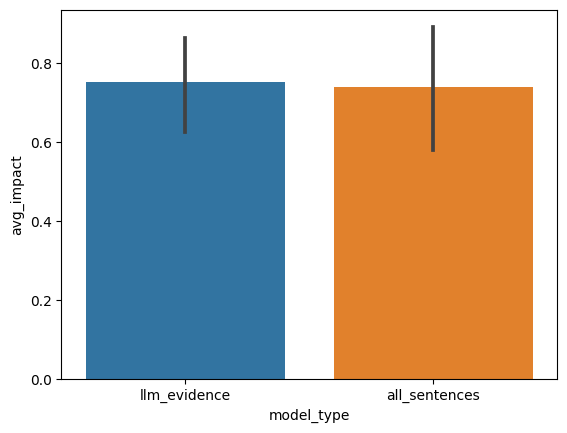

/work/frink/mcinerney.de/envs/ehrenvint/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


<Axes: xlabel='model_type', ylabel='avg_impact'>

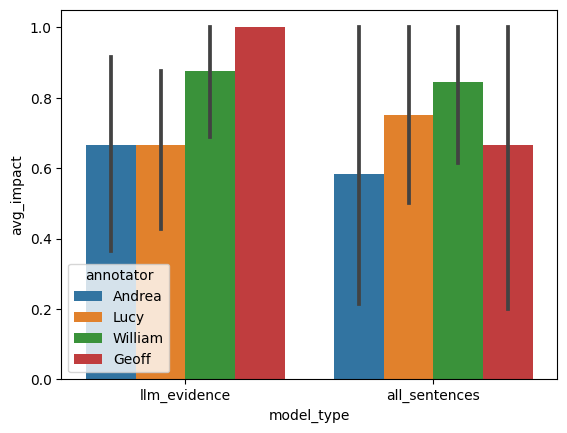

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(data=evidence_df, x='model_type', y='avg_impact')
plt.show()
sns.barplot(data=evidence_df, x='model_type', y='avg_impact', hue='annotator')



<Axes: xlabel='num_reports', ylabel='time_for_initial_assesment'>

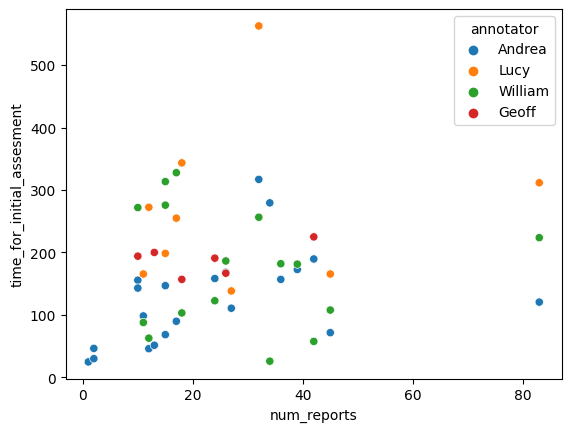

In [46]:
import seaborn as sns
sns.scatterplot(data=processed_df, x='num_reports', y='time_for_initial_assesment', hue='annotator')

In [47]:
from collections import Counter
instance_counts = []
for i, row in processed_df.iterrows():
    if row['sort_type'] != row['sort_type']:
        continue
    instance_counts.append(Counter())
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]]:
        for x in zip(*[row[k] for k in relevance_keys]):
            instance_counts[-1][max(x)] += 1
    instance_counts[-1] = dict(instance_counts[-1])
    instance_counts[-1]['annotator'] = row['annotator']
    instance_counts[-1]['model'] = (row['model_type'], row['sort_type'])
    instance_counts[-1]['instance_index'] = row['instance_index']
instance_counts = pd.DataFrame(instance_counts)
instance_counts

,1,annotator,model,instance_index,0,2,3
0,1.0,Andrea,"(llm_evidence, LLM Confidence)",49,NaN,NaN,NaN
1,1.0,Andrea,"(llm_evidence, LLM Confidence)",51,1.0,NaN,NaN
2,NaN,Andrea,"(llm_evidence, LLM Confidence)",52,3.0,NaN,NaN
3,1.0,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",53,NaN,NaN,NaN
4,NaN,Andrea,"(llm_evidence, LLM Confidence)",66,3.0,NaN,NaN
5,2.0,Andrea,"(all_sentences, Sort by MSE with the bias logits)",68,NaN,NaN,NaN
6,NaN,Andrea,"(all_sentences, Sort by MSE with the bias logits)",75,5.0,NaN,NaN
7,NaN,Andrea,"(llm_evidence, LLM Confidence)",84,2.0,NaN,NaN
8,1.0,Andrea,"(all_sentences, Sort by MSE with the bias logits)",86,1.0,1.0,NaN
9,NaN,Andrea,"(llm_evidence, Sort by MSE with the bias logits)",94,NaN,NaN,2.0


In [48]:
import numpy as np
instance_counts_expanded = pd.DataFrame([])
for x in range(4):
    df = instance_counts[[c for c in instance_counts.columns if not isinstance(c, int)]]
    df['count'] = instance_counts[x]
    df['max_usefulness'] = [x] * len(df)
    instance_counts_expanded = pd.concat([instance_counts_expanded, df])
instance_counts_expanded = instance_counts_expanded.sort_values('instance_index')
instance_counts_expanded

/tmp/ipykernel_8605/1565988942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['count'] = instance_counts[x]
/tmp/ipykernel_8605/1565988942.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['max_usefulness'] = [x] * len(df)
/tmp/ipykernel_8605/1565988942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

,annotator,model,instance_index,count,max_usefulness
26,William,"(llm_evidence, LLM Confidence)",0,NaN,2
26,William,"(llm_evidence, LLM Confidence)",0,NaN,3
17,Andrea,"(all_sentences, Sort by MSE with the bias logits)",0,NaN,3
26,William,"(llm_evidence, LLM Confidence)",0,1.0,0
10,Lucy,"(llm_evidence, Sort by MSE with the bias logits)",0,1.0,0
...,...,...,...,...,...
39,Geoff,"(llm_evidence, LLM Confidence)",135,1.0,1
25,Andrea,"(all_sentences, Sort by MSE with the bias logits)",135,1.0,1
25,Andrea,"(all_sentences, Sort by MSE with the bias logits)",135,NaN,2
25,Andrea,"(all_sentences, Sort by MSE with the bias logits)",135,NaN,3


In [49]:
df = instance_counts_expanded.groupby(['max_usefulness', 'model', 'annotator', 'instance_index']).agg({'count': np.sum}).reset_index()
df['model'] = df['model'].astype(str)
print({model: set(df[df.model == model].annotator) for model in set(df.model)})
# df = df.groupby(['max_usefulness', 'model']).agg({'count': lambda x: (x.mean(), x.std())}).reset_index()
# df['count (averaged over annotators)'] = df['count'].apply(lambda x: x[0])
# df['count stddev'] = df['count'].apply(lambda x: x[1])
df

{"('all_sentences', 'Sort by MSE with the bias logits')": {'Geoff', 'Lucy', 'Andrea', 'William'}, "('llm_evidence', 'Sort by MSE with the bias logits')": {'Lucy', 'Andrea', 'William'}, "('llm_evidence', 'LLM Confidence')": {'Geoff', 'Lucy', 'Andrea', 'William'}}


,max_usefulness,model,annotator,instance_index,count
0,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,0,1.0
1,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,68,0.0
2,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,75,5.0
3,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,86,1.0
4,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,135,1.0
...,...,...,...,...,...
187,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,49,0.0
188,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,54,1.0
189,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,86,1.0
190,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,111,1.0


<Axes: xlabel='max_usefulness', ylabel='count'>

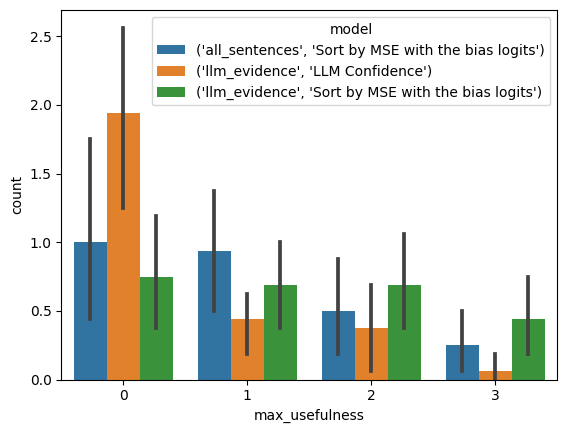

In [50]:
sns.barplot(data=df, x='max_usefulness', y='count', hue='model')

In [51]:
df

,max_usefulness,model,annotator,instance_index,count
0,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,0,1.0
1,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,68,0.0
2,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,75,5.0
3,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,86,1.0
4,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,135,1.0
...,...,...,...,...,...
187,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,49,0.0
188,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,54,1.0
189,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,86,1.0
190,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,111,1.0


('all_sentences', 'Sort by MSE with the bias logits')
43
('llm_evidence', 'Sort by MSE with the bias logits')
41
('llm_evidence', 'LLM Confidence')
45


(-0.5, 2.5, -0.15000000000000002, 3.15)

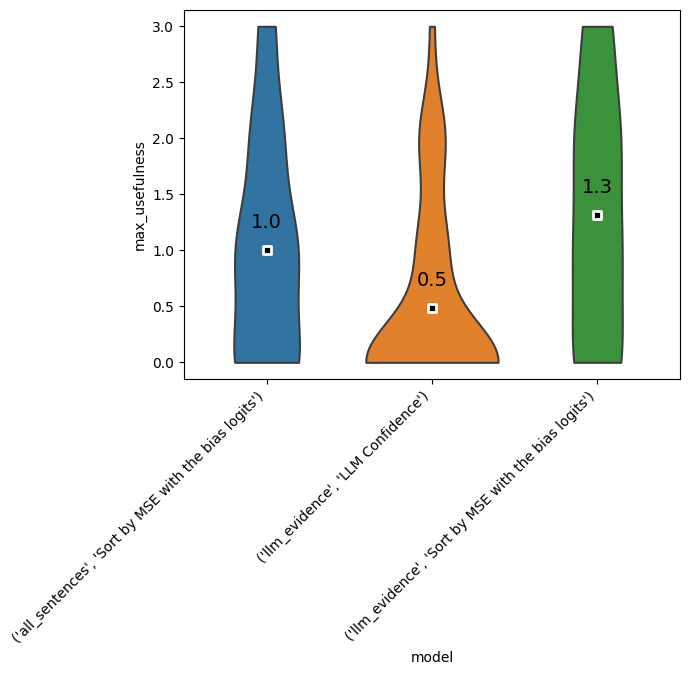

In [52]:
df_expanded = []
for i, row in df.iterrows():
    row = dict(row)
    count = row['count']
    del row['count']
    assert count.is_integer()
    for _ in range(int(count)):
        df_expanded.append(row)
df_expanded = pd.DataFrame(df_expanded)
for x in set(df_expanded.model):
    print(x)
    print((df_expanded.model == x).sum())
chart = sns.violinplot(data=df_expanded, y='max_usefulness', x='model', cut=0, inner=None)
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45, 
    horizontalalignment='right'
)
axis=chart.axis()
mean_data = df_expanded.groupby('model').agg({'max_usefulness': np.mean})
sns.scatterplot(data=mean_data, x='model', y='max_usefulness', ax=chart, color='black', marker='s', linewidth=2)
for i, row in mean_data.iterrows():
    chart.annotate('%.1f' % row.max_usefulness, xy=(i, row.max_usefulness + .2), horizontalalignment='center', color='black', fontsize=14)
chart.axis(axis)

# mean_data = pd.concat([df[(~df.is_custom_prompt) & (df.Model == m)].groupby(['Model']).mean() for m in models])
# chart1 = sns.violinplot(data=df[~df.is_custom_prompt], x='Model', y='Recall', cut=0, linewidth=1, ax=axs[0], bw=.6, inner=None, order=models, palette=palette)
# axis=chart1.axis()
# chart1 = sns.scatterplot(data=mean_data, x='Model', y='Recall', ax=chart1, color='black', marker='s', linewidth=2)
# for i, row in mean_data.iterrows():
#     chart1.annotate('%.1f' % row.Recall, xy=(i, row.Recall + .2), horizontalalignment='center', color='black', fontsize=14)


In [53]:
df['Not Relevant'] = df.apply(lambda r: r['count'] if r.max_usefulness == 0 else 0., axis=1)
df['Weak Correlation'] = df.apply(lambda r: r['count'] if r.max_usefulness == 1 else 0., axis=1)
df['Useful'] = df.apply(lambda r: r['count'] if r.max_usefulness == 2 else 0., axis=1)
df['Very Useful'] = df.apply(lambda r: r['count'] if r.max_usefulness == 3 else 0., axis=1)
df

,max_usefulness,model,annotator,instance_index,count,Not Relevant,Weak Correlation,Useful,Very Useful
0,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,0,1.0,1.0,0.0,0.0,0.0
1,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,68,0.0,0.0,0.0,0.0,0.0
2,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,75,5.0,5.0,0.0,0.0,0.0
3,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,86,1.0,1.0,0.0,0.0,0.0
4,0,"('all_sentences', 'Sort by MSE with the bias l...",Andrea,135,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
187,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,49,0.0,0.0,0.0,0.0,0.0
188,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,54,1.0,0.0,0.0,0.0,1.0
189,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,86,1.0,0.0,0.0,0.0,1.0
190,3,"('llm_evidence', 'Sort by MSE with the bias lo...",William,111,1.0,0.0,0.0,0.0,1.0


<Axes: xlabel='model,annotator'>

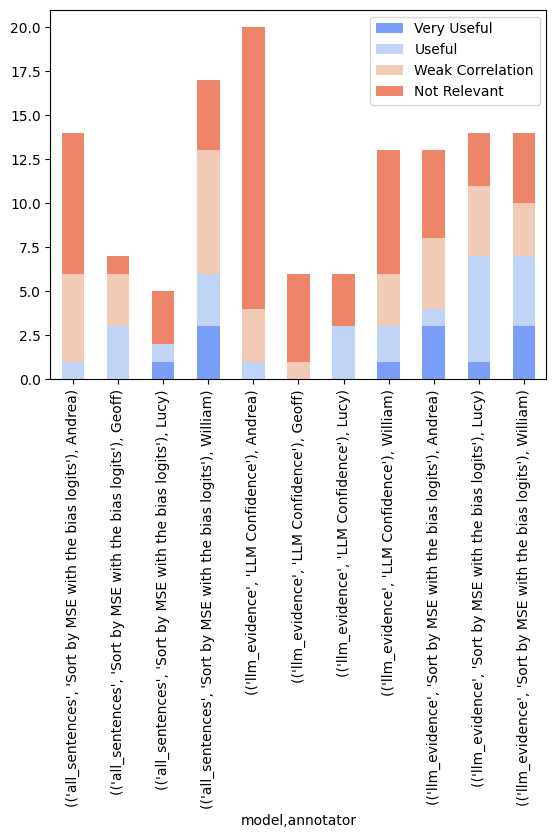

In [54]:
df_stacked = df.groupby(['model', 'annotator']).agg(np.sum)
df_stacked[['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']].plot(kind='bar', stacked=True, color=sns.color_palette("coolwarm", 4))

Andrea
William
Geoff


Lucy


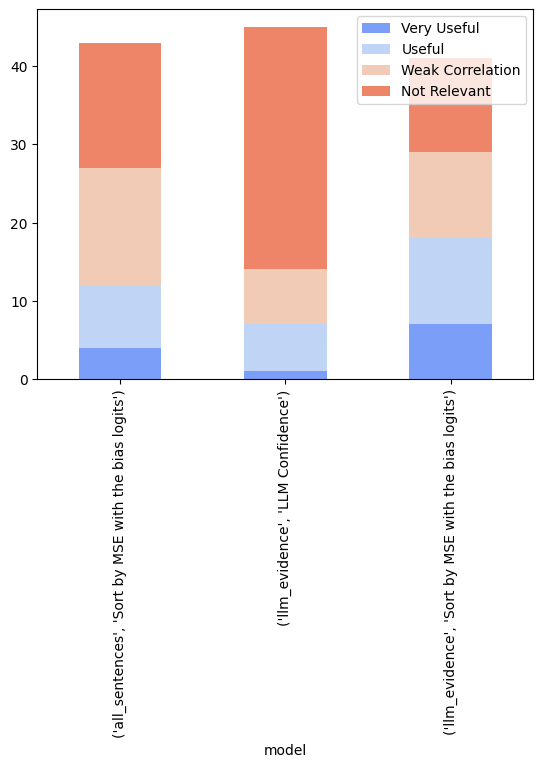

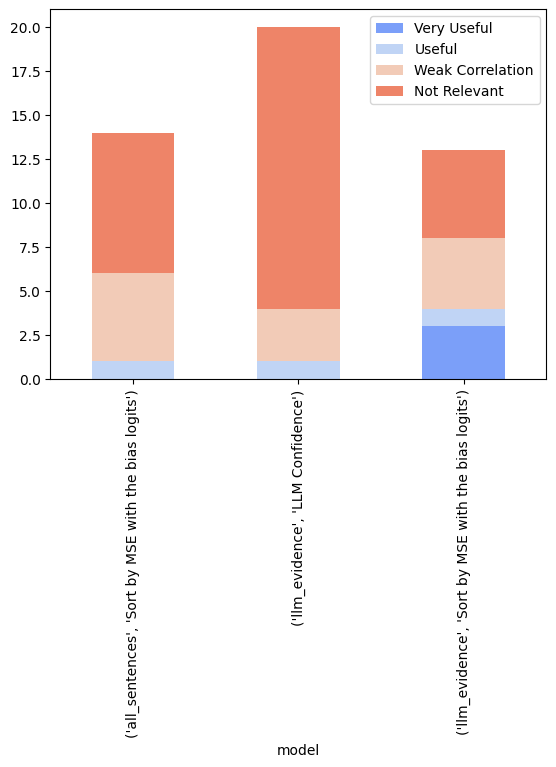

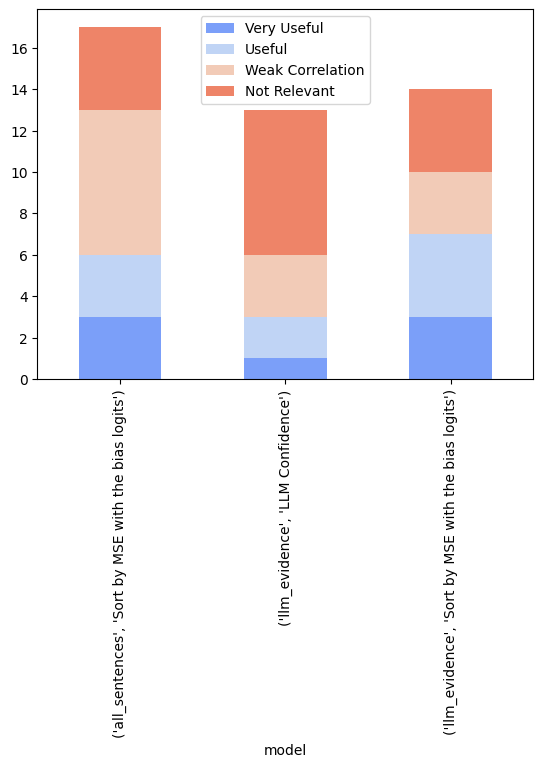

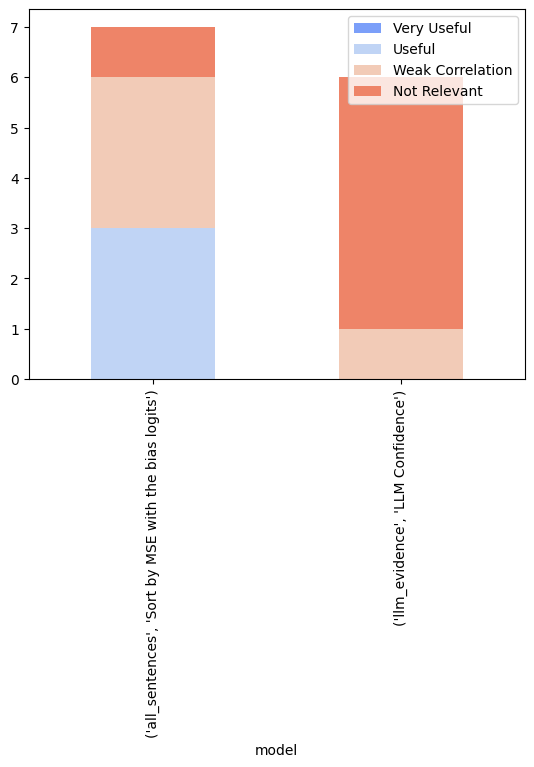

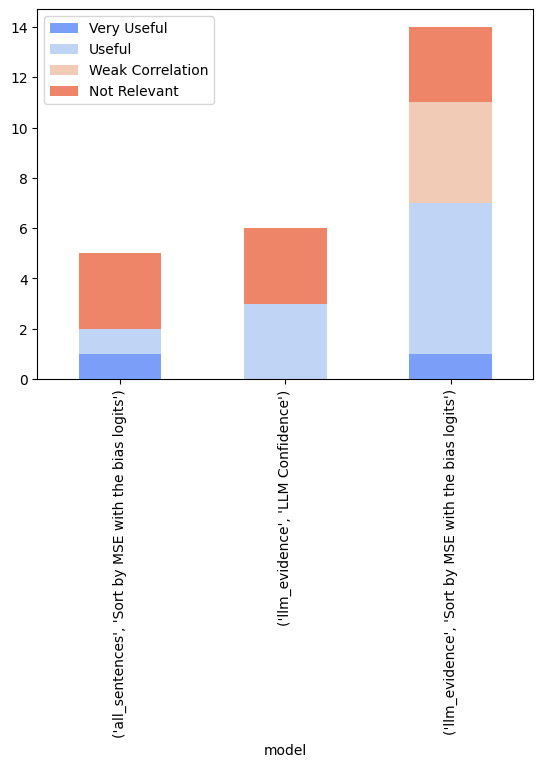

In [55]:
df_stacked = df.groupby(['model']).agg(np.sum)
df_stacked[['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']].plot(kind='bar', stacked=True, color=sns.color_palette("coolwarm", 4))
for annotator in ['Andrea', 'William', 'Geoff', 'Lucy']:
    print(annotator)
    df_stacked = df[df.annotator == annotator].groupby(['model']).agg(np.sum)
    df_stacked[['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']].plot(kind='bar', stacked=True, color=sns.color_palette("coolwarm", 4))    

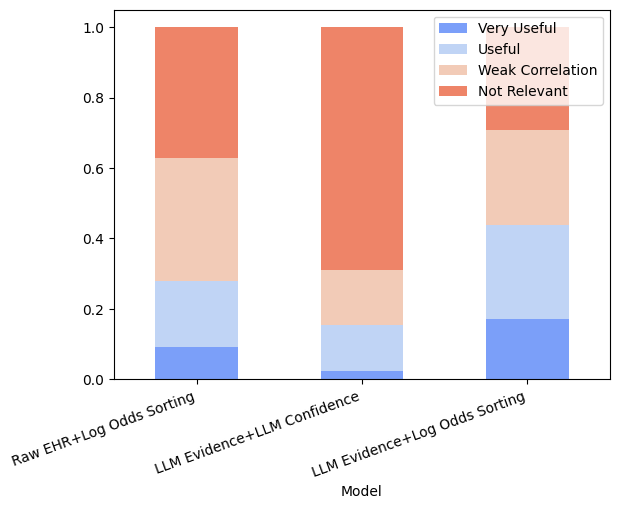

In [56]:
df_stacked = df.groupby(['model']).agg(np.sum).reset_index()
models = {'llm_evidence': 'LLM Evidence', 'all_sentences': 'Raw EHR'}
sort_methods = {'Sort by MSE with the bias logits': 'Log Odds Sorting', 'LLM Confidence': 'LLM Confidence'}
df_stacked['Model'] = df_stacked['model'].apply(lambda x: models[eval(x)[0]]+'+'+sort_methods[eval(x)[1]])
df_stacked = df_stacked.set_index('Model')
ratings = ['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']
for x in ratings:
    df_stacked[x] = df_stacked.apply(lambda r: r[x] / r['count'], axis=1)
chart = df_stacked[
    ['Very Useful', 'Useful', 'Weak Correlation', 'Not Relevant']].plot(
    kind='bar', stacked=True, color=sns.color_palette("coolwarm", 4),
    # order=['LLM Evidence+LLM Confidence',
    #        'Raw EHR+Log Odds Sorting',
    #        'LLM Evidence+Log Odds Sorting']
           )
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=20, 
    horizontalalignment='right'
)
axis=chart.axis()

/tmp/ipykernel_8605/4062501099.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(


[Text(0, 0, "('all_sentences', 'Sort by MSE with the bias logits')"),
 Text(1, 0, "('llm_evidence', 'LLM Confidence')"),
 Text(2, 0, "('llm_evidence', 'Sort by MSE with the bias logits')")]

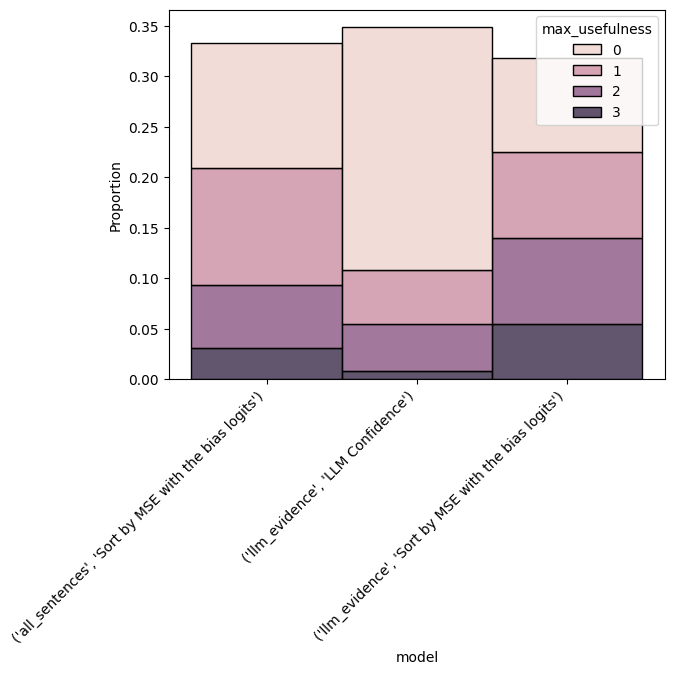

In [57]:
chart = sns.histplot(data=df_expanded, hue='max_usefulness', x='model', stat='proportion', multiple="stack")
chart.set_xticklabels(
    chart.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [58]:
df_expanded['count'] = [1] * len(df_expanded)
df_collapsed = df_expanded.groupby(['model', 'annotator']).agg({'count': np.sum, 'max_usefulness': lambda x: (np.mean(x), np.std(x))})
df_collapsed['avg_usefulness'] = [x[0] for x in df_collapsed['max_usefulness']]
df_collapsed['stddev_usefulness'] = [x[1] for x in df_collapsed['max_usefulness']]
del df_collapsed['max_usefulness']
df_collapsed

count   
model                                              annotator          
('all_sentences', 'Sort by MSE with the bias lo... Andrea        14  \
                                                   Geoff          7   
                                                   Lucy           5   
                                                   William       17   
('llm_evidence', 'LLM Confidence')                 Andrea        20   
                                                   Geoff          6   
                                                   Lucy           6   
                                                   William       13   
('llm_evidence', 'Sort by MSE with the bias log... Andrea        13   
                                                   Lucy          14   
                                                   William       14   

                                                              avg_usefulness   
model                                              annotator                   
('all_sentences', 'Sort by MSE with the bias lo... Andrea           0.500000  \
                                                   Geoff            1.285714   
                                                   Lucy             1.000000   
                                                   William          1.294118   
('llm_evidence', 'LLM Confidence')                 Andrea           0.250000   
                                                   Geoff            0.166667   
                                                   Lucy             1.000000   
                                                   William          0.769231   
('llm_evidence', 'Sort by MSE with the bias log... Andrea           1.153846   
                                                   Lucy             1.357143   
                                                   William          1.428571   

                                                              stddev_usefulness  
model                                              annotator                     
('all_sentences', 'Sort by MSE with the bias lo... Andrea              0.626783  
                                                   Geoff               0.699854  
                                                   Lucy                1.264911  
                                                   William             1.015452  
('llm_evidence', 'LLM Confidence')                 Andrea              0.536190  
                                                   Geoff               0.372678  
                                                   Lucy                1.000000  
                                                   William             0.973009  
('llm_evidence', 'Sort by MSE with the bias log... Andrea              1.166596  
                                                   Lucy                0.894997  
                                                   William             1.115750

In [59]:
from collections import Counter
query_counts = defaultdict(lambda : Counter())
for i, row in processed_df.iterrows():
    relevance_keys = [k for k in row.keys() if k.endswith(' relevance')]
    if row[relevance_keys[0]] == row[relevance_keys[0]] and \
            row['query'] == row['query']:
        for x in zip(row['query'], *[row[k] for k in relevance_keys]):
            query_counts[x[0]][max(x[1:])] += 1
query_counts = pd.DataFrame(query_counts).transpose()
query_counts

,1,3,2,0
cancer (diagnosis),7.0,3.0,2.0,4.0
pulmonary edema (diagnosis),2.0,1.0,NaN,4.0
pneumonia (diagnosis),4.0,2.0,5.0,1.0
tiredness (risk factor),NaN,1.0,NaN,4.0
a low ejection fraction (risk factor),3.0,NaN,5.0,5.0
neuralogical problems (risk factor),1.0,1.0,1.0,10.0
a history of smoking (risk factor),NaN,NaN,NaN,1.0
jaundice (risk factor),NaN,NaN,NaN,1.0
a compromised immune system (risk factor),NaN,NaN,2.0,1.0
large neck lymph nodes (risk factor),1.0,NaN,NaN,2.0
